# Introduction

The following notebook is our solution to the Multivariate Timeseries Forecasting challenge of the course Artificial Neural Networks and Deep Learning from Politecnico di Milano, A.Y. 2021/2022

The following code has been used to build our best model on the test set used during the development phase, several other models have been tried and clearly described in the full report of our decision process. In this notebook we have decided to insert our best model and at the end there is also a fully convolutional model (vgg for monodimensional data) which we have described in a dedicated chapter of the report.

In the report we clearly describe the hyperparameter tuning phase used during the challenge. In this notebook we omit this tuning part since it is not relevant to be shown

Team name: romano_ercolani

Members:
* Romanò Francesco
* Ercolani Antonio

# Data Loading and Setup

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Load the dataset as a pandas dataframe
dataset = pd.read_csv('../input/anndltimeseriesforecasting/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
# Show statistics of the dataset
dataset.describe()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,6.094102,4.695539,13.337485,2.448660,2.407010,23.237929,8.231283
std,1.941639,3.374224,11.703203,3.001798,0.994063,14.298260,11.285101
min,-0.972080,-8.450380,-37.581721,-9.028060,-1.275860,-6.006860,-42.769221
25%,4.791440,2.223420,10.672820,0.468800,2.112200,12.560240,6.604160
50%,5.702780,4.668600,15.676059,2.533840,2.618500,20.151420,10.968300
75%,7.067300,7.115440,20.568080,4.656980,3.021880,31.245199,15.334100
max,15.106680,18.122899,41.138801,14.035980,6.056360,77.371620,31.024420


In [5]:
# Show info of different variables of the multivariate dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


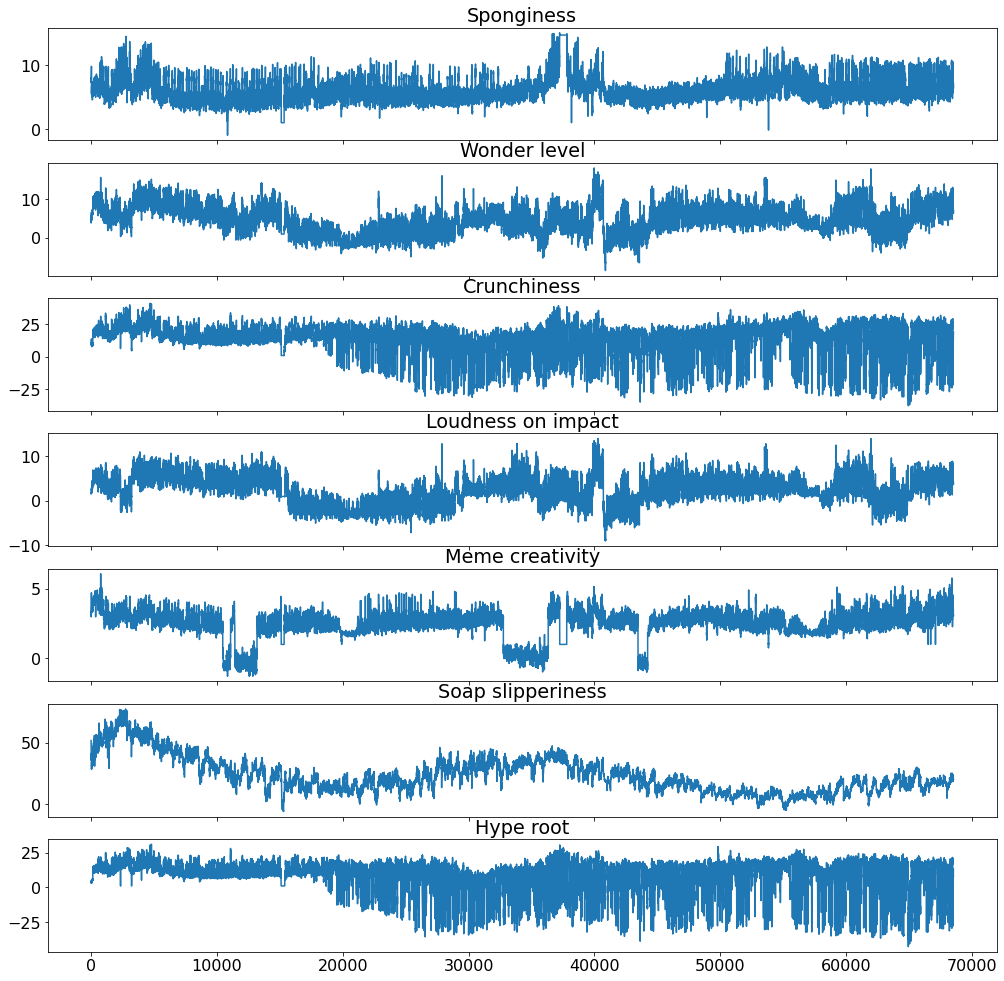

In [6]:
# Plot the overall dataset time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [7]:
# Split the dataset
from math import ceil, floor

split = 0.9

n_total = dataset["Sponginess"].count()
n_train = ceil(n_total * split)
n_test = floor(n_total * (1-split))

print("Training samples: ", n_train)
print("Validation samples: ", n_test)

Training samples:  61676
Validation samples:  6852


(61676, 7) (6852, 7)


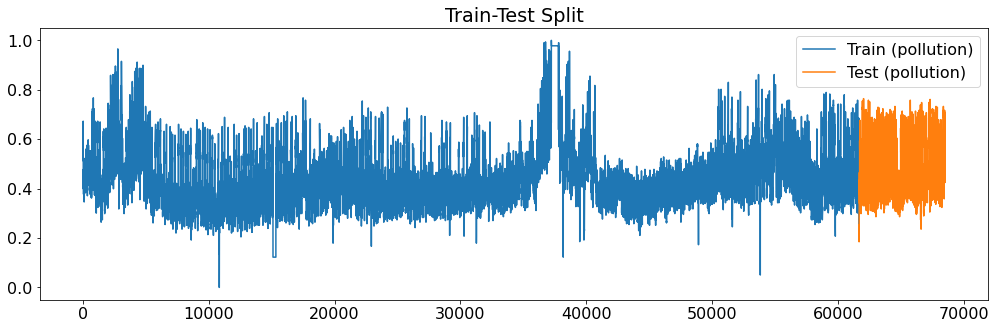

In [8]:
# Split dataset and create the Test set
test_size = n_test
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (pollution)')
plt.plot(X_test_raw.Sponginess, label='Test (pollution)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
# Set values of window and stride (they have been tuned properly as described in the report)
# These hyperparameter guide the training, since we give to the model the task of making predictions for a single window each time during training, in order to have lots of predictions useful for training
# The stride is simply how much we move on along the sequence to extract the next window
window = 250
stride = 10

In [11]:
# Utility function used to build sequences to be fed into our NN
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
# Set the telescope (i.e. how many samples our model will predict given)
target_labels = dataset.columns
telescope = 864

In [13]:
# Create the sequences ready to be used by our model
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6064, 250, 7), (6064, 864, 7), (589, 250, 7), (589, 864, 7))

In [14]:
# Utility function to plot samples of window + samples to be predicted for each variable
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

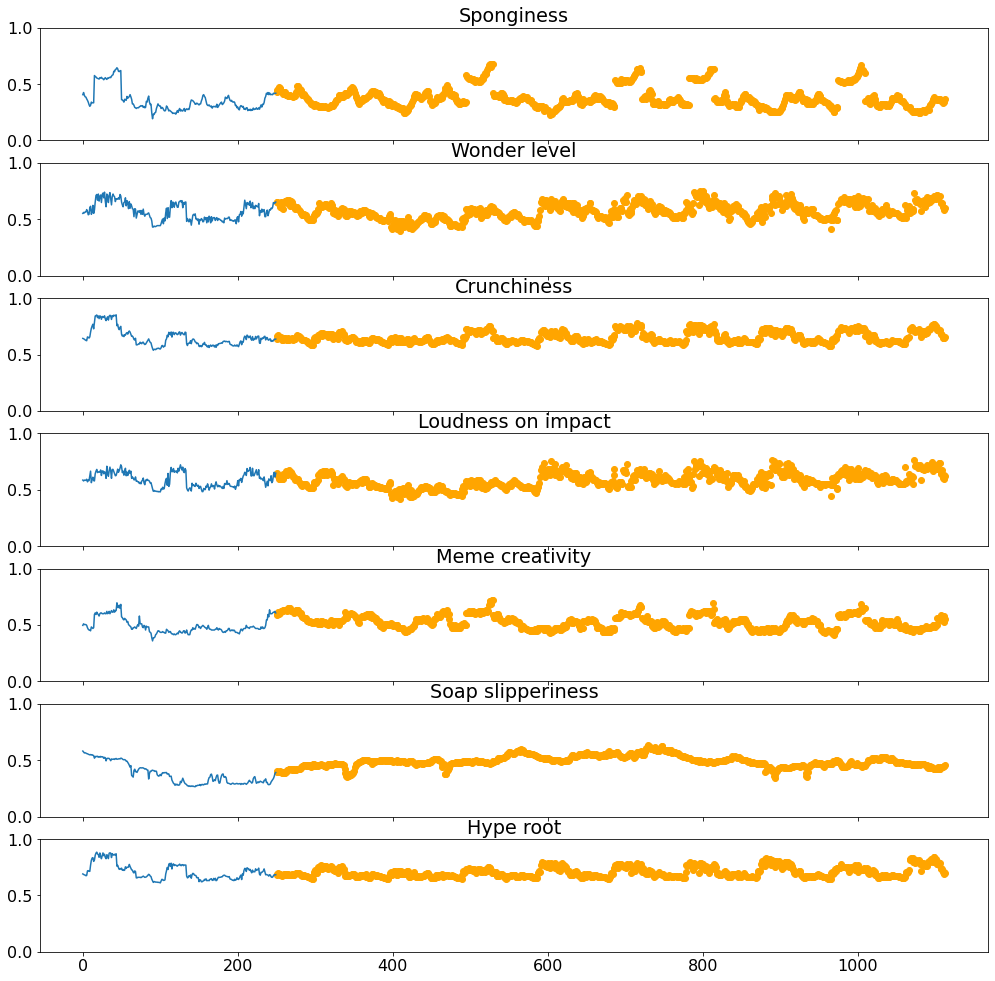

In [15]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

# Our best model

We now build train and validate the best performing model we have created. Its design is better described in the report

In [16]:
# setting model metadata
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
input_shape, output_shape

((250, 7), (864, 7))

In [17]:
# Utility function to build our model
def build_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    
    #Our best model
    vgg = tf.keras.Sequential()

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape, name='Input'))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50), input_shape=input_shape))
    model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(output_shape[-1]*output_shape[-2], activation='relu'))
    model.add(tf.keras.layers.Reshape((output_shape[-2],output_shape[-1])))
    
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    # Return the model
    return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100)               23200     
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              206848    
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6048)              12392352  
_________________________________________________________________
reshape_3 (Reshape)          (None, 864, 7)            0         
Total params: 12,622,400
Trainable params: 12,622,400
Non-trainable params: 0
_________________________________________________________________


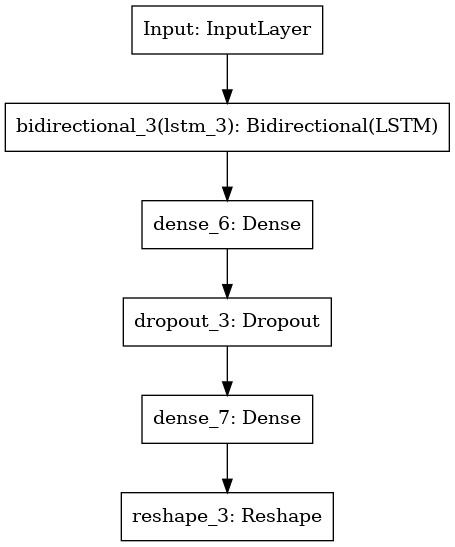

In [21]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

## 10-fold Cross validation

In [22]:
# Implementation of K Fold cross-validation due to highly noisy results with just hold out evaluation
from sklearn.model_selection import KFold

num_folds = 10

histories = []
scores = []
mses = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print("Starting training on fold num: {}".format(fold_idx+1))
    
    model = build_LSTM_model(input_shape, output_shape)
    
    history = model.fit(
        x = X_train[train_idx],
        y = y_train[train_idx],
        validation_data=(X_train[valid_idx], y_train[valid_idx]),
        batch_size = batch_size,
        epochs = 30,
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
                     tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
                    ]
    ).history

    score = model.evaluate(X_train[valid_idx], y_train[valid_idx])
    scores.append(score[1])
    
    predictions = model.predict(X_train[valid_idx])
    mse = tfk.metrics.mse(y_train[valid_idx].flatten(),predictions.flatten())
    print(mse, mse.shape)
    mses.append(mse)

    histories.append(history)

Starting training on fold num: 1
Epoch 1/30
86/86 [==============================] - 5s 37ms/step - loss: 0.0389 - mae: 0.1408 - val_loss: 0.0180 - val_mae: 0.0975
Epoch 2/30
86/86 [==============================] - 2s 26ms/step - loss: 0.0157 - mae: 0.0899 - val_loss: 0.0130 - val_mae: 0.0807
Epoch 3/30
86/86 [==============================] - 2s 26ms/step - loss: 0.0125 - mae: 0.0805 - val_loss: 0.0111 - val_mae: 0.0766
Epoch 4/30
86/86 [==============================] - 2s 28ms/step - loss: 0.0111 - mae: 0.0769 - val_loss: 0.0101 - val_mae: 0.0732
Epoch 5/30
86/86 [==============================] - 2s 26ms/step - loss: 0.0103 - mae: 0.0746 - val_loss: 0.0092 - val_mae: 0.0704
Epoch 6/30
86/86 [==============================] - 2s 27ms/step - loss: 0.0097 - mae: 0.0723 - val_loss: 0.0089 - val_mae: 0.0680
Epoch 7/30
86/86 [==============================] - 2s 26ms/step - loss: 0.0095 - mae: 0.0717 - val_loss: 0.0089 - val_mae: 0.0687
Epoch 8/30
86/86 [==============================] 

In [23]:
print("Average score found by 10 fold cross validation:")
print(np.mean(scores))
print("Average mse found by 10 fold cross validation:")
np.mean(mses)

Average score found by 10 fold cross validation:
0.06000365167856216
Average mse found by 10 fold cross validation:


0.006936597

In [24]:
# Train the model

model = build_LSTM_model(input_shape, output_shape)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
86/86 [==============================] - 6s 33ms/step - loss: 0.0392 - mae: 0.1412 - val_loss: 0.0214 - val_mae: 0.1082
Epoch 2/200
86/86 [==============================] - 3s 32ms/step - loss: 0.0155 - mae: 0.0903 - val_loss: 0.0151 - val_mae: 0.0841
Epoch 3/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0120 - mae: 0.0798 - val_loss: 0.0127 - val_mae: 0.0804
Epoch 4/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0106 - mae: 0.0758 - val_loss: 0.0116 - val_mae: 0.0781
Epoch 5/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0099 - mae: 0.0730 - val_loss: 0.0113 - val_mae: 0.0770
Epoch 6/200
86/86 [==============================] - 2s 27ms/step - loss: 0.0093 - mae: 0.0710 - val_loss: 0.0112 - val_mae: 0.0755
Epoch 7/200
86/86 [==============================] - 2s 26ms/step - loss: 0.0091 - mae: 0.0699 - val_loss: 0.0107 - val_mae: 0.0743
Epoch 8/200
86/86 [==============================] - 2s 26ms/step - loss: 0.

Below we plot the usual training plot which monitors various performance metrics (the loss which is MSE, and also the metric MAE) computed both for training and validation. It is also plotted the value of the learning rate at different epochs, since we used a callback that reduces gradually the lr when the model starts to converge

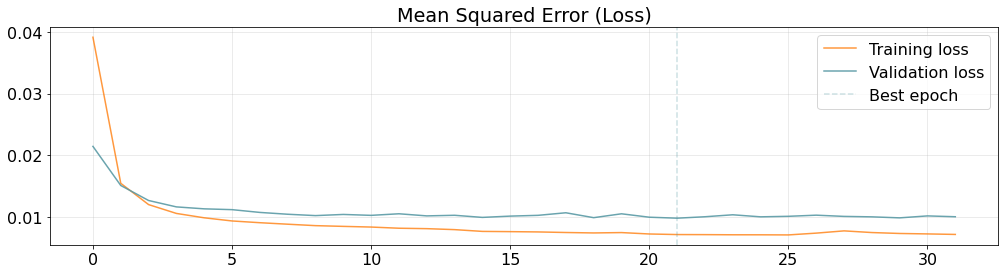

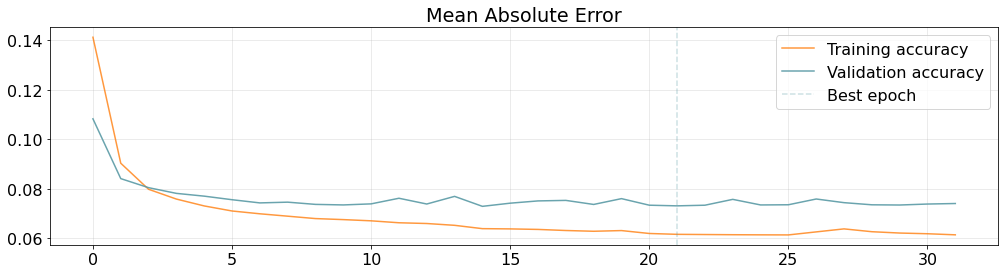

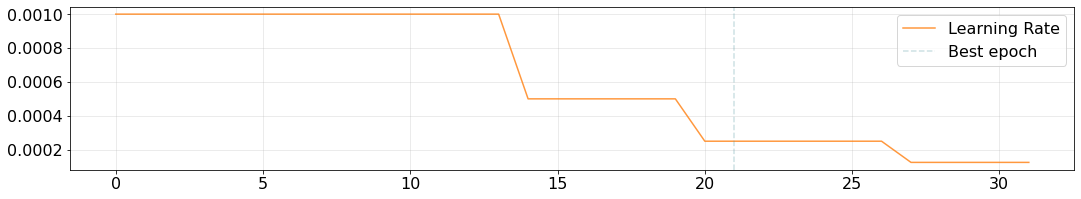

In [25]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('lstm_dense_model')

In [26]:
X_test.shape

(589, 250, 7)

In [27]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(589, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.011334203>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.077686734>)

Observation: this mse score is done with a Hold-out approach, the scores found by cross validation are more robust to noise

In [28]:
# Utility function to plot our model predictions (green) compared with respect to real samples of the time series to be predicted (orange)
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

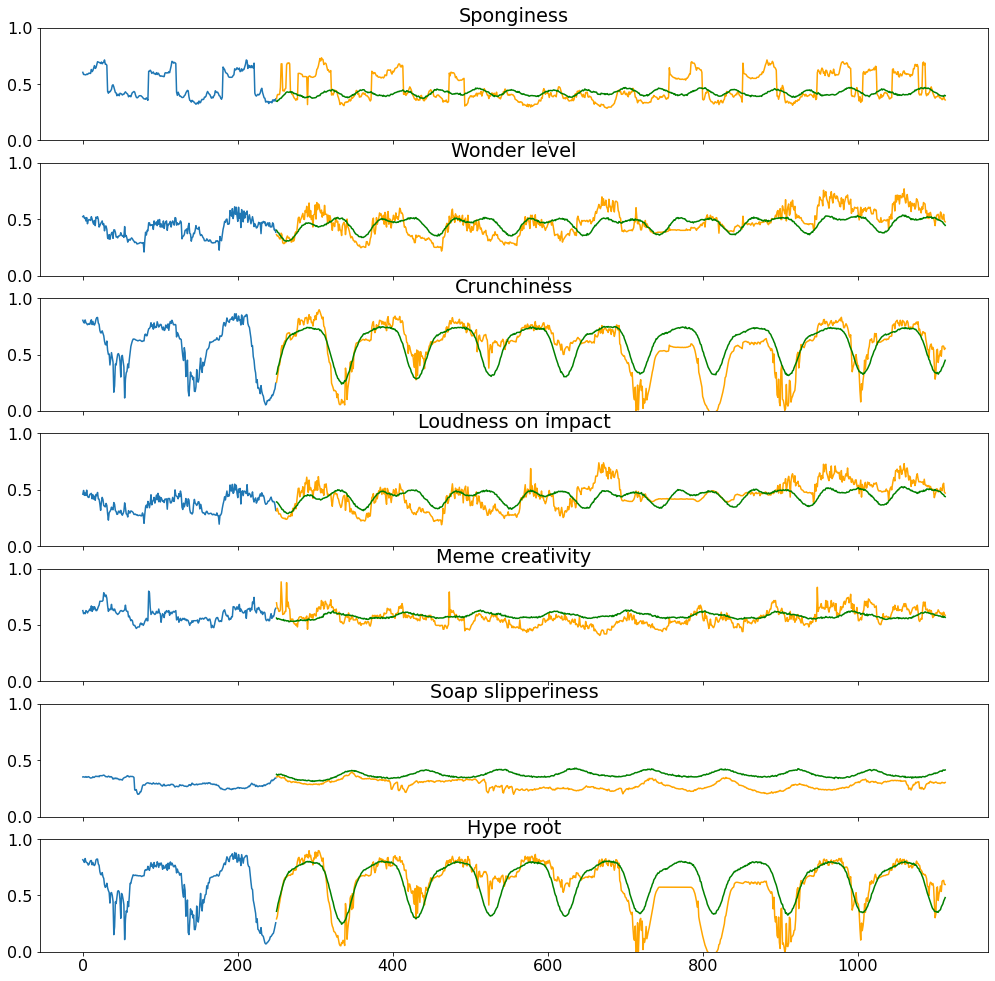

In [29]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

Below we plot predictions for future data, showing also the interval given by the MAE metric highlighting how it evolves (the error increases with longer predictions)

In [30]:
# Here we define as future the last part of our dataset with the size of a window
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 250, 7)

In [32]:
# Creation of a list containing all values of MAE to be plotted
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [33]:
future_predictions = model.predict(future)

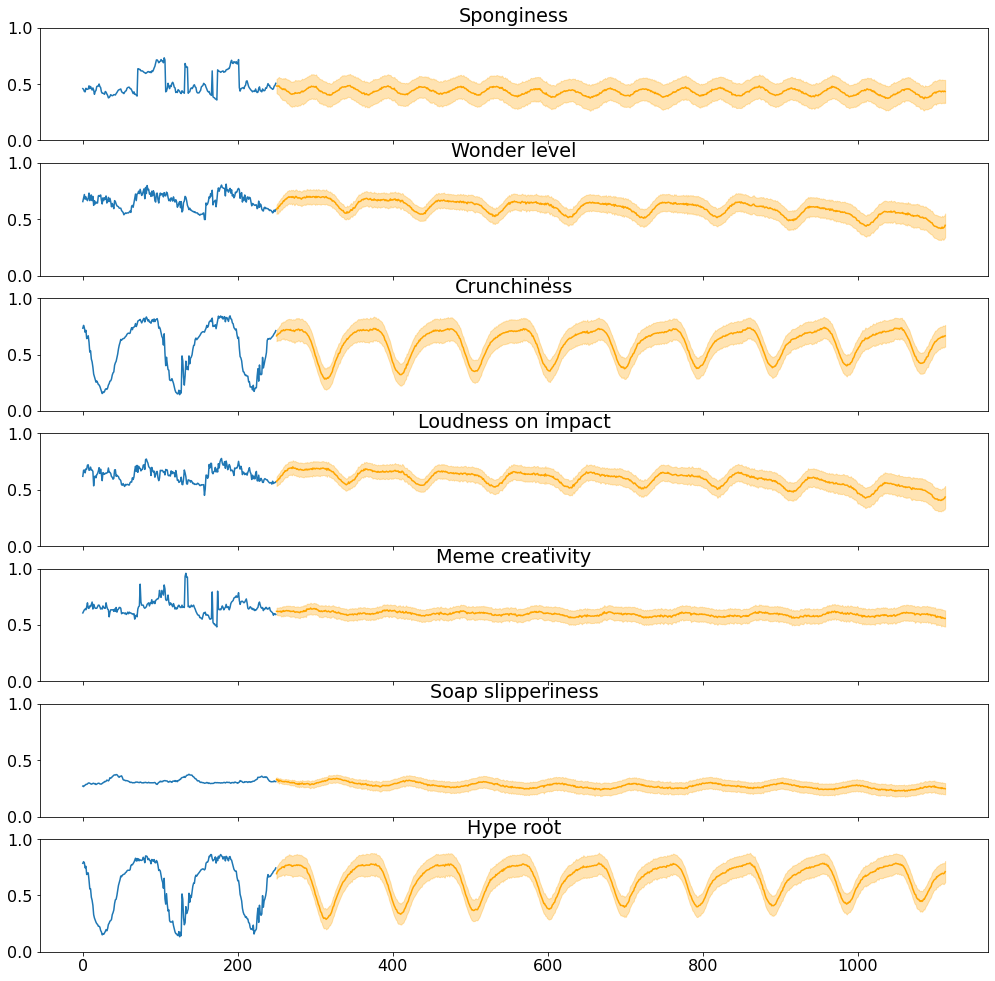

In [37]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()

# Implementation of VGG model

Here we show our implementation of a monodimensional vgg model. Results of this attempt are clearly described in the report, here we just wanted to show it to compare with our best Recurrent model

In [38]:
def build_vgg_model(input_shape, output_shape):
    # Build the neural network layer by layer
    
    #MY MODEL
    vgg = tf.keras.Sequential()

    vgg.add(tf.keras.layers.Conv1D(input_shape=input_shape,filters=64,kernel_size=3,padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
    vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    vgg.add(tf.keras.layers.GlobalMaxPooling1D())
    #vgg.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)))
    vgg.add(tf.keras.layers.Dense(output_shape[-1]*output_shape[-2], activation='relu'))
    vgg.add(tf.keras.layers.Reshape((output_shape[-2],output_shape[-1])))


    vgg.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tfk.losses.MeanSquaredError(),
        metrics = ['mae', 'mse']
    )
    
    # Return the model
    return vgg

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 250, 64)           1408      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 128)          24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 62, 256)         

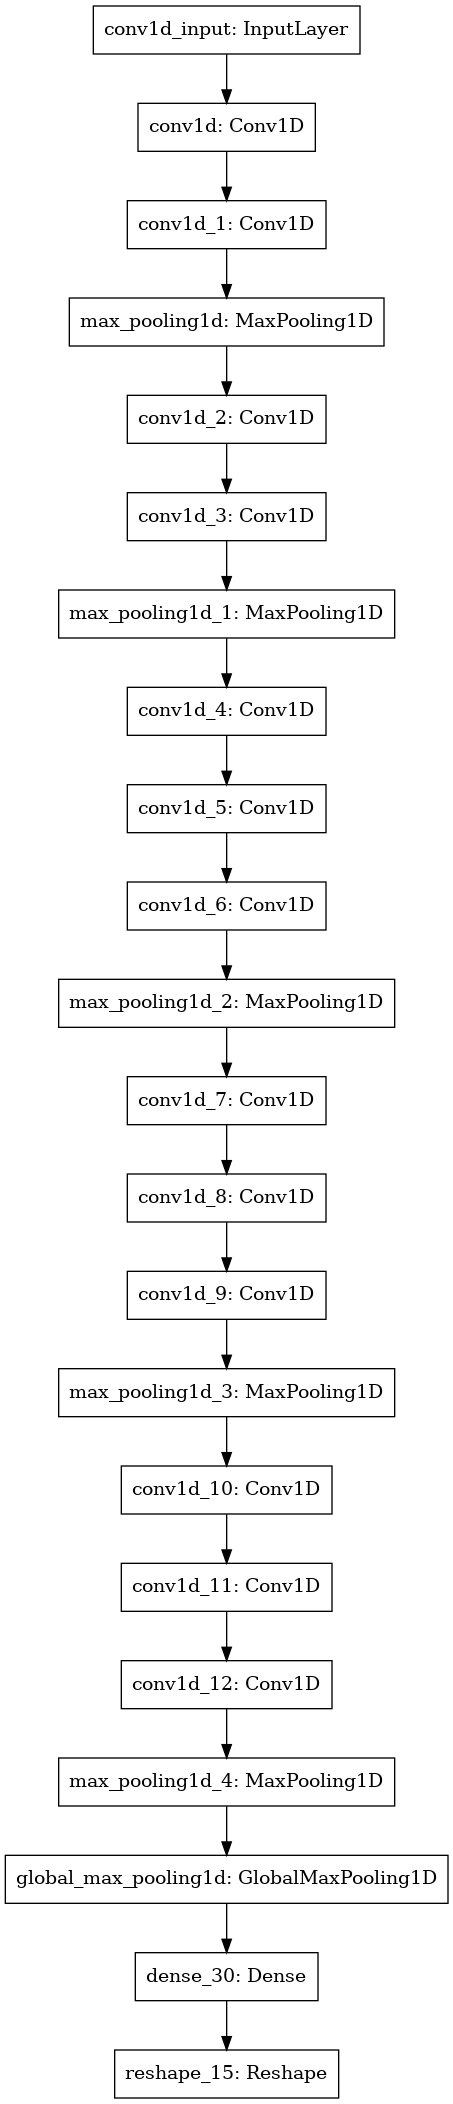

In [39]:
model = build_vgg_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

## 10-fold Cross validation for vgg

In [40]:
# Implementation of K Fold cross-validation due to highly noisy results with just hold out evaluation
from sklearn.model_selection import KFold

num_folds = 10

histories = []
scores = []
mses = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print("Starting training on fold num: {}".format(fold_idx+1))
    
    model = build_vgg_model(input_shape, output_shape)
    
    history = model.fit(
        x = X_train[train_idx],
        y = y_train[train_idx],
        validation_data=(X_train[valid_idx], y_train[valid_idx]),
        batch_size = batch_size,
        epochs = 30,
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
                     tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
                    ]
    ).history

    score = model.evaluate(X_train[valid_idx], y_train[valid_idx])
    scores.append(score[1])
    
    predictions = model.predict(X_train[valid_idx])
    mse = tfk.metrics.mse(y_train[valid_idx].flatten(),predictions.flatten())
    print(mse, mse.shape)
    mses.append(mse)

    histories.append(history)

Starting training on fold num: 1
Epoch 1/30
86/86 [==============================] - 9s 32ms/step - loss: 0.1788 - mae: 0.3073 - mse: 0.1788 - val_loss: 0.0684 - val_mae: 0.1762 - val_mse: 0.0684
Epoch 2/30
86/86 [==============================] - 2s 24ms/step - loss: 0.0666 - mae: 0.1746 - mse: 0.0666 - val_loss: 0.0670 - val_mae: 0.1740 - val_mse: 0.0670
Epoch 3/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0662 - mae: 0.1738 - mse: 0.0662 - val_loss: 0.0670 - val_mae: 0.1753 - val_mse: 0.0670
Epoch 4/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0662 - mae: 0.1738 - mse: 0.0662 - val_loss: 0.0667 - val_mae: 0.1743 - val_mse: 0.0667
Epoch 5/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0662 - mae: 0.1736 - mse: 0.0662 - val_loss: 0.0669 - val_mae: 0.1750 - val_mse: 0.0669
Epoch 6/30
86/86 [==============================] - 2s 23ms/step - loss: 0.0661 - mae: 0.1735 - mse: 0.0661 - val_loss: 0.0665 - val_mae: 0.1735 - val_m

In [41]:
print("Average score found by 10 fold cross validation:")
print(np.mean(scores))
print("Average mse found by 10 fold cross validation:")
np.mean(mses)

Average score found by 10 fold cross validation:
0.08166244328022003
Average mse found by 10 fold cross validation:


0.01972231

Observation: as expected the cross validation score is not very good, probably due to the problem of this approach described in the report (few predictions are non-sense)

In [42]:
model = build_vgg_model(input_shape, output_shape)

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
86/86 [==============================] - 3s 26ms/step - loss: 0.1543 - mae: 0.2740 - mse: 0.1543 - val_loss: 0.0676 - val_mae: 0.1785 - val_mse: 0.0676
Epoch 2/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0669 - mae: 0.1754 - mse: 0.0669 - val_loss: 0.0669 - val_mae: 0.1783 - val_mse: 0.0669
Epoch 3/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0668 - mae: 0.1752 - mse: 0.0668 - val_loss: 0.0664 - val_mae: 0.1748 - val_mse: 0.0664
Epoch 4/200
86/86 [==============================] - 2s 24ms/step - loss: 0.0666 - mae: 0.1745 - mse: 0.0666 - val_loss: 0.0678 - val_mae: 0.1779 - val_mse: 0.0678
Epoch 5/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0664 - mae: 0.1742 - mse: 0.0664 - val_loss: 0.0662 - val_mae: 0.1749 - val_mse: 0.0662
Epoch 6/200
86/86 [==============================] - 2s 23ms/step - loss: 0.0664 - mae: 0.1742 - mse: 0.0664 - val_loss: 0.0661 - val_mae: 0.1751 - val_mse: 0.0661
Epoch 7/200
86/8

Below we plot the same graphs showed before for the previous model to have a quick visual comparison

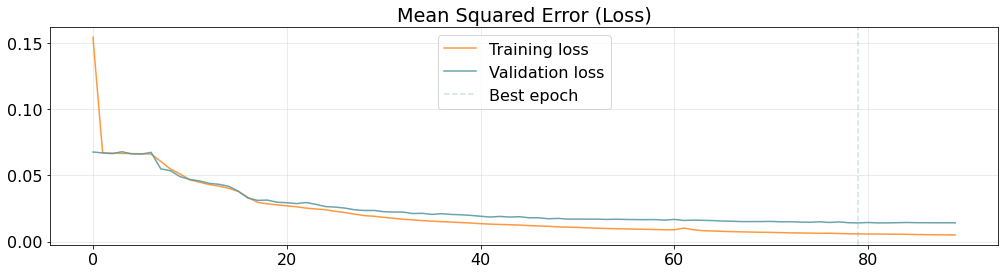

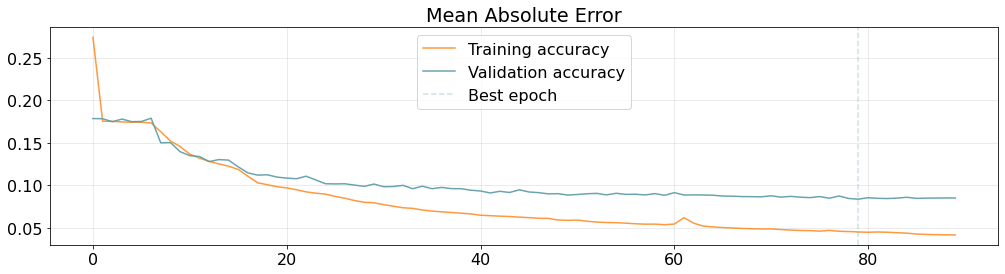

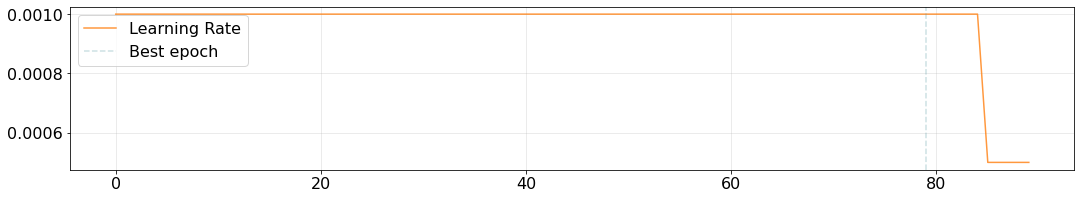

In [43]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [44]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(589, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.017099246>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09421141>)

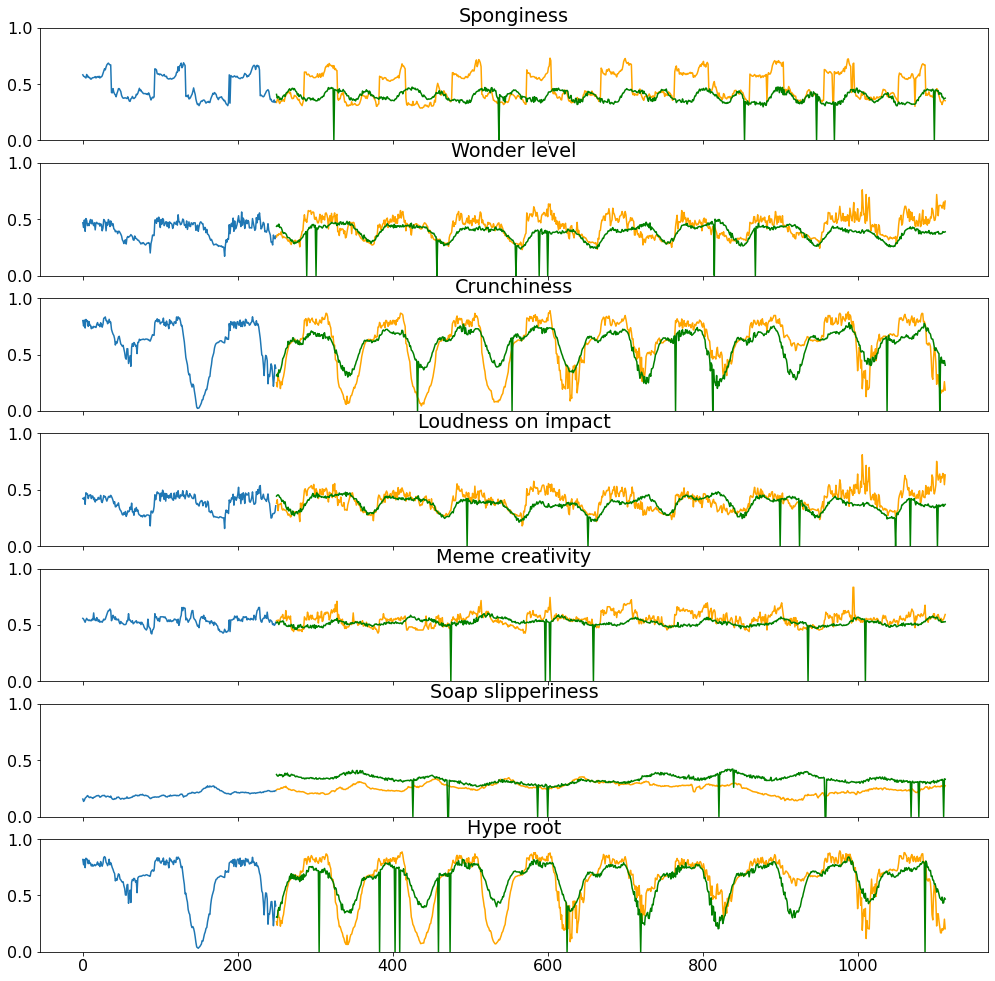

In [45]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [46]:
# Creation of a list containing all values of MAE to be plotted
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [47]:
future_predictions = model.predict(future)

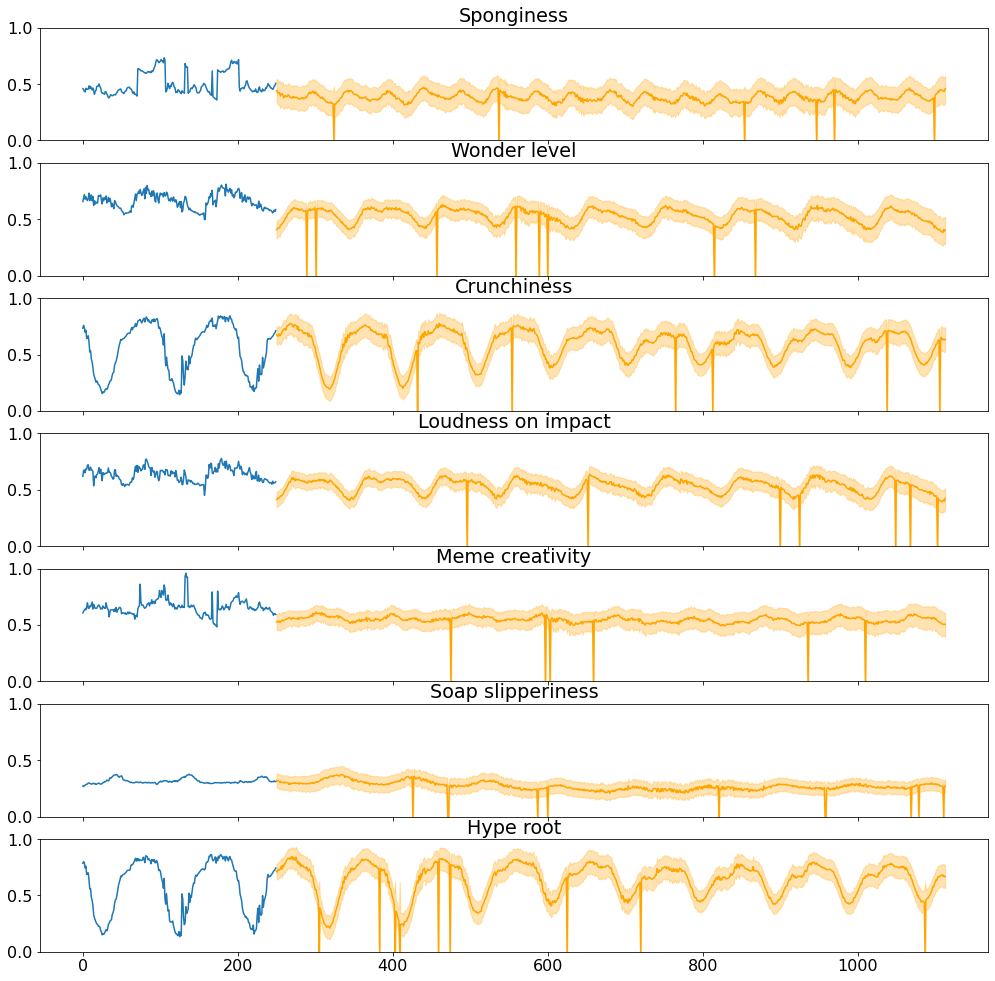

In [48]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()